# Logistic Regression

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Data Import
df = pd.read_csv('Diabetes.csv')
df.set_index('patient_id',inplace=True)

In [3]:
df.head()

,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
patient_id,,,,,,,,,,
1,19,M,7,0,0,0,0,0,0,No
2,24,F,59,0,0,0,0,0,0,No
3,4,F,43,0,0,0,0,0,0,No
4,38,M,66,0,0,0,0,0,1,No
5,46,F,98,0,0,0,0,0,1,No


Age                    0
Gender                 0
Prescription_period    0
Diabetes               0
Alcoholism             0
HyperTension           0
Smokes                 0
Tuberculosis           0
Sms_Reminder           0
Adherence              0
dtype: int64

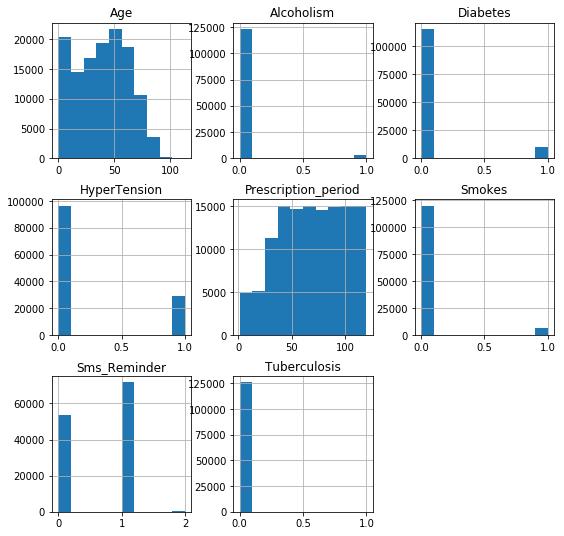

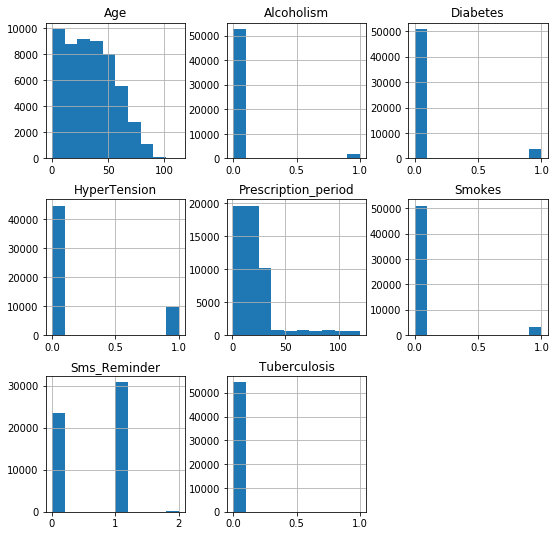

In [4]:
# Data Exploration
df.groupby('Adherence').hist(figsize=(9, 9))
df.isnull().sum()
#df.corr()

In [6]:
# one hot encoding
df_dummy = pd.get_dummies(df.iloc[:,:-1])
df_dummy.head()

,Age,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Gender_F,Gender_M
patient_id,,,,,,,,,,
1,19,7,0,0,0,0,0,0,0,1
2,24,59,0,0,0,0,0,0,1,0
3,4,43,0,0,0,0,0,0,1,0
4,38,66,0,0,0,0,0,1,0,1
5,46,98,0,0,0,0,0,1,1,0


In [8]:
df.head()

,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
patient_id,,,,,,,,,,
1,19,M,7,0,0,0,0,0,0,No
2,24,F,59,0,0,0,0,0,0,No
3,4,F,43,0,0,0,0,0,0,No
4,38,M,66,0,0,0,0,0,1,No
5,46,F,98,0,0,0,0,0,1,No


In [25]:
 # Data Split training & test set
X_train, X_test, y_train, y_test = train_test_split(df_dummy.iloc[:,:-1], df.iloc[:,-1], test_size=0.2)

In [26]:
# Multi Model Perfromance analysis

models = []

models.append(('LR', LogisticRegression()))
models.append(('AB', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [35]:
names = []
scores = []
for mdl, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(mdl)
    
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
tr_split

,Name,Score
0,LR,0.824154
1,AB,0.893988
2,RF,0.869545
3,GB,0.893683


In [49]:
# K fold Validation

names = []
scores = []
for mdl, model in models:
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X_test, y_test, cv=kfold, scoring='accuracy').mean()
    
    names.append(mdl)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
kf_cross_val

,Name,Score
0,LR,0.823544
1,AB,0.893960
2,RF,0.869739
3,GB,0.893849


In [29]:
# Gradient Boosting performs the best with threshold of 0.5

# Feature Selection

model_gb = GradientBoostingClassifier()
rfecv = RFECV(estimator=model_gb, step=1, cv=kfold, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=10, random_state=10, shuffle=False),
   estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

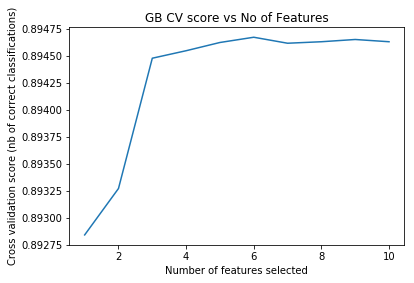

In [30]:
plt.figure()
plt.title('GB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [31]:
feature_names = X_train.columns
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])

X_train_ = X_train[new_features]

initial_score = cross_val_score(model_gb, X_train, y_train, cv=kfold, scoring='accuracy').mean()

fe_score = cross_val_score(model_gb, X_train_, y_train, cv=kfold, scoring='accuracy').mean()

In [32]:
# Grid Search
param_grid = {'n_estimators':range(20,100,30)}
              #'max_depth':range(5,16,2), 
              #'min_samples_split':range(200,1001,200), 
              #'min_samples_leaf':range(30,71,10)}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='accuracy')
grid.fit(X_train_, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(20, 100, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [45]:
# Final Model
metrics_gb_gstrn = classification_report(y_train,grid.predict(X_train[new_features]))

metrics_gb_gstst = classification_report(y_test,grid.predict(X_test[new_features]))

result = pd.DataFrame(grid.predict_proba(df_dummy[new_features]))

result['Adherence'] = grid.predict(df_dummy[new_features])

df.reset_index(inplace=True)

result['Patient ID'] = df['patient_id']

result.columns = ['NO','YES','Adherence','Patient_ID']

col = ['Patient_ID','Adherence','NO','YES']

result = result[col]

result.to_csv('Result.csv')